# P4 Computational Vision

**Important:** Read the file `README.md` before start coding.

<div class = "alert alert-info" style = "border-radius:10px;border-width:3px;border-color:darkblue;font-family:Verdana,sans-serif;font-size:16px;">

**Delivery**
<ol>

Requirements to fulfill:
<ul>
    <li>  Answer the questions introduced in the exercises.   
    <li>  The implemented code should be,<br>
        - optimized ( e.g. do not use 'for' instruction when indexing numpy arrays)<br>
        - readable  ( e.g. avoiding the implementation of more than 2 loops within a line)<br>
        - commented and with descriptions        
    <li> Add title to the figures to explain what is displayed.
    <li> The deliverable must be a file named **P4_Student1_Student2.zip** that includes:
    <ul>
        <li> The notebook P4_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    </ul>

</ul>

 **Deadline (Campus Virtual): October 28th, 23:00 h** 


</ol>
</div>


## Practicum 4: Descriptors extraction for object detection based on ORB


In this laboratory we will treat the following topic: Image matching (recognition by correspondance) based on feature extraction (ORB). Application to object (logo) detection.

It is highly recommendable to structure the code in functions in order to reuse code for different tests and images and make it shorter and more readable. Specially the visualization commands should be encapsulated in separate functions.

In [1]:
from glob import glob

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

from skimage.feature import corner_fast, corner_peaks, ORB, match_descriptors, plot_matches
from skimage.transform import rotate
from skimage.color import rgb2gray

# ORB feature detection and description

Let us consider the problem of feature extraction that contains two subproblems: 
- feature location, 
- image feature description.

Let us focus on ORB, an approximation of SIFT method, and analyse if ORB is  scale and rotation invariant, a property that is very important for real-time applications.

**Hint:** `ORB` is a function within the module `skimage.feature`
                             
**Help**: We suggest to have a look at the [ORB example](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html) how to compute the ORB descriptors and find the descriptors match. You can use the function match_descriptors from `skimage.feature` module in order to compute and show the similar detected descriptors of the given images. 

**Exercise 1.** 

(a) Detect the corners in the image `starbucks4.jpg`. 
Use `corner_fast` to extract FAST corners for the given image and `corner_peaks` to find corners in the corner measure response image.

Follow this example for visualization:

    fast= corner_fast(img)
    corner_points = corner_peaks(fast)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.scatter(corner_points[:, 1], corner_points[:, 0], facecolors='none', edgecolors='r')

Comment your code in detail.

(b) Analyze and discuss the effect of different values of the parameter `threshold` in the corner_fast function.



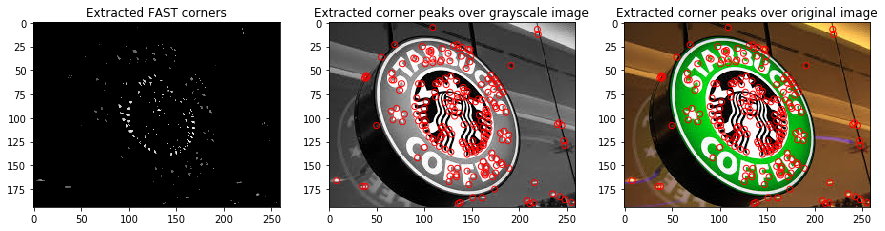

In [2]:
# Read image
img = io.imread('images/starbucks4.jpg')

# Convert image to grayscale
# The input image for `corner_fast` must be 2D
gs_img = rgb2gray(img)

# Extract FAST corners of the image. Params:
#    - n: number of consecutive pixels around the test value that
#         should be brighter (xor darker) w.r.t. the test pixel.
#    - threshold: value to decide whether pixels are lighter or darker.
fast = corner_fast(gs_img, n=12, threshold=0.15)

# Find corners in corner measure response image. Used params:
#    - min_distance: min distance to don't join peaks.
#    - threshold: minimum intensity of the peaks.
corner_points = corner_peaks(fast, min_distance=1, threshold_abs=None, threshold_rel=0.1)

# Plot results.
f, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(fast, cmap='gray')
ax[0].set_title('Extracted FAST corners')

ax[1].imshow(gs_img, cmap='gray')
ax[1].scatter(corner_points[:, 1], corner_points[:, 0], facecolors='none', edgecolors='r')
ax[1].set_title('Extracted corner peaks over grayscale image')

ax[2].imshow(img)
ax[2].scatter(corner_points[:, 1], corner_points[:, 0], facecolors='none', edgecolors='r')
ax[2].set_title('Extracted corner peaks over original image')

plt.show()

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
Once we have converted the image into grayscale (as `skimage.feature.corner_fast` requires a 2D image), we extract its FAST corners. Features from Accelerated Segment Test (FAST) are extracted with a relatively efficient corner detection technique, and with corner_peaks we detect the actual corners (coordinates) from the features. Finally, we plot the results of each step.

</div>

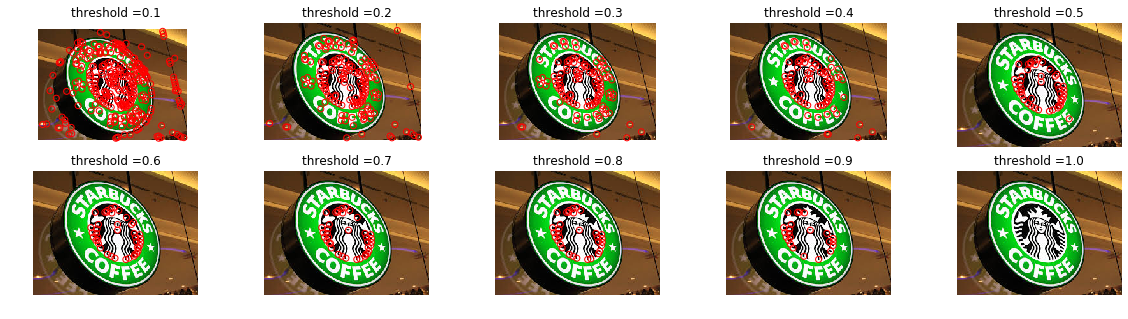

In [3]:
f, ax = plt.subplots(2, 5, figsize=(20, 5))

for idx, thresh in enumerate(np.arange(0.1, 1.1, 0.1)):
    fast = corner_fast(gs_img, threshold=thresh)
    corner_points = corner_peaks(fast)

    ax[idx // 5][idx % 5].imshow(img, cmap='gray')
    ax[idx // 5][idx % 5].scatter(corner_points[:, 1], corner_points[:, 0], facecolors='none', edgecolors='r')
    ax[idx // 5][idx % 5].axis('off')
    ax[idx // 5][idx % 5].title.set_text('threshold =' + '{0:.1f}'.format(thresh))

plt.show()

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
Discussion of the effect of the parameter `threshold`: As we can see in the above plots, the greater the threshold value, the less corners are detected, because the pixels which luminosity that do not pass the threshold are discarded. Remarkably, starting at `threshold=0.6`, only corners within the inner circle of the Starbucks logo are detected, where the black/white contrast is most notorius.

</div>

**Exercise 2.** 

(a) Detect the correspondences between the model image `starbucks.jpg` with the scene image `starbucks4.jpg`. You can adapt the code from the [ORB example](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html). Define the algorithm in terms of functions in order to be able to apply it on different images. Comment the code in detail.

(b) Analyze and discuss the effect of different values of the parameter `max_ratio` in the match_descriptors function.

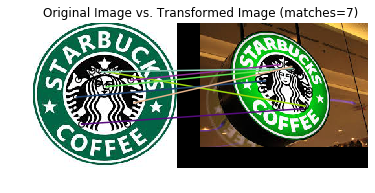

In [4]:
def display_correspondences(img1, img2, kp=20, max_ratio=1.0, title=None, ax=None):
    gs_img1 = rgb2gray(img1)
    gs_img2 = rgb2gray(img2)
    
    if ax is None:
        ax = plt.axes()

    # ORB isntance for kp keypoints
    descriptor_extractor = ORB(n_keypoints=kp)
    
    # Extract keypoints and descriptors of the first image
    descriptor_extractor.detect_and_extract(gs_img1)
    keypoints1 = descriptor_extractor.keypoints
    descriptors1 = descriptor_extractor.descriptors

    # Extract keypoints and descriptors of the second image
    descriptor_extractor.detect_and_extract(gs_img2)
    keypoints2 = descriptor_extractor.keypoints
    descriptors2 = descriptor_extractor.descriptors

    # Create matches between both images
    matches = match_descriptors(descriptors1, descriptors2, cross_check=True, max_ratio=max_ratio)
    
    # Plot Results
    plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
    
    title = f'matches={len(matches)}' if title is None else f'{title}, matches={len(matches)}'
    ax.set_title(f'Original Image vs. Transformed Image ({title})')
    ax.axis('off')

img_model = io.imread('images/starbucks.jpg')
display_correspondences(img_model, img)

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
Oriented FAST and rotated BRIEF (ORB) is a free alternative to SIFT for detecting local features in a relatively robust way (*i.e.* at least approximately invariant to certain transformations). Essentially:
1. We extract the keypoints and descriptors, by using the given ORB built-in functions for both images.
2. Then we match them trying to find common points, with a function which finds the closest descriptor in the second set for each descriptor in the first set.
3. Finally, let's display both images and their matched keypoints.

</div>

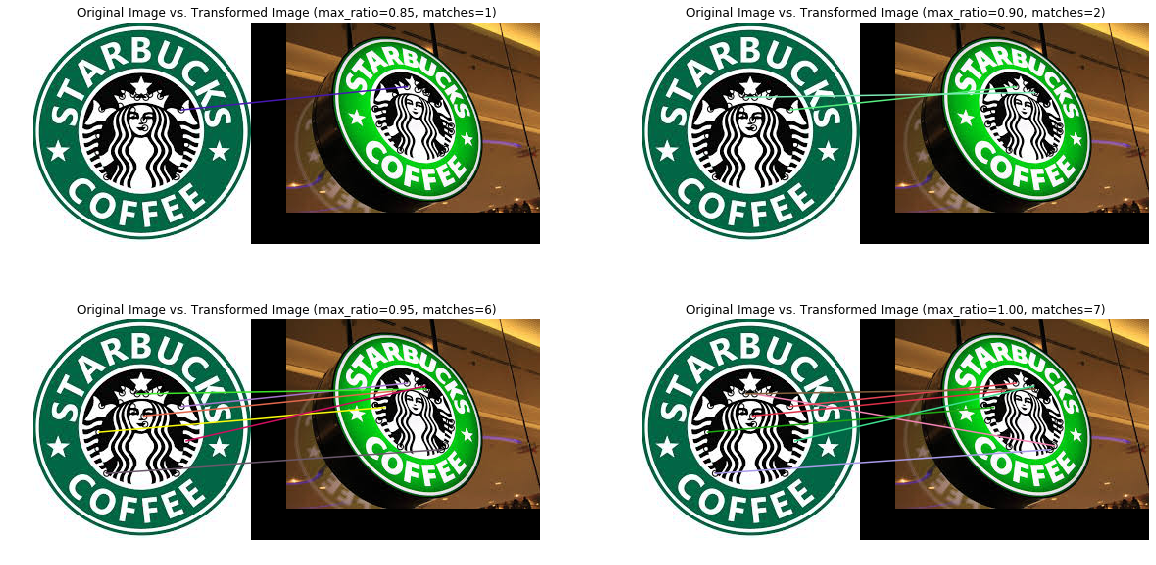

In [5]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))

for idx, max_ratio in enumerate(np.arange(0.85, 1.01, 0.05)):
    corner_points = corner_peaks(fast, threshold_rel=thresh)
    display_correspondences(img_model, img,
                            max_ratio=max_ratio,
                            ax=ax[idx // 2][idx % 2],
                            title=f'max_ratio={max_ratio:.2f}')

plt.show()

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
`max_ratio` is the maximum ratio of distances between the first and second closest descritprs in the descriptors of the second image, according to the [documentation](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.match_descriptors). Essentially, it works as a threshold for discarding potentially ambiguous matches. If the threshold is too low, all matches are discarded. If it's too big, perhaps some 'false' matches are detected. However, in this case, since the two images are actually very similar, discarding matches does not seem to be a good idea.

</div>

**Exercise 3.** Repeate the experiment comparing the "starbucks.jpg" image as a model, and showing its matches to all Starbucks images. Add a title in each figure indicating the number of the matches for the pair. Comment when does the algorithm work better. 

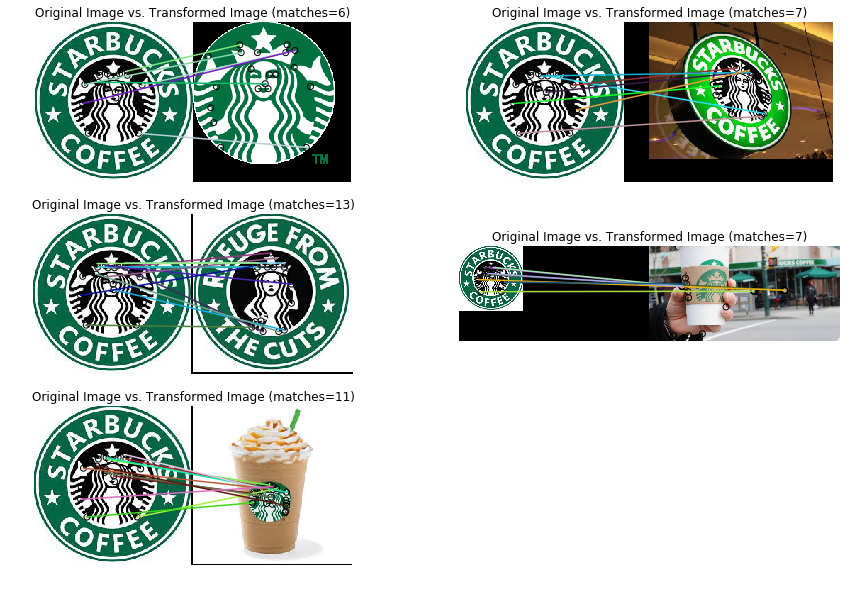

In [6]:
f, ax = plt.subplots(3, 2, figsize=(15, 10))

for idx, path in enumerate(sorted(glob('images/starbucks*'))):
    if path == 'images/starbucks.jpg':
        continue
    
    # Read image and remove transparency 
    img = io.imread(path)[:, :, :3]
        
    display_correspondences(img_model, img, ax=ax[(idx - 1) // 2][(idx - 1) % 2])

plt.axis('off')
plt.show()

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
As we could expect, factors such as orientation can make the matching way more difficult. In the case of the 4th image, the Starbucks cup has an occlusion (the fingers of the buyer) and the logo is not exactly the same, so the algorithm struggles to correctly match. For similar images (orientation, intensities, shape...) works very good, as for the first image of the second row.

</div>

**Exercise 4.** Repeat the experiment in exercise 3., changing the orientation of the model image by rotating it and comparing it with its original version. 
  
**Help:** You can use the rotate() function from skimage.transform.


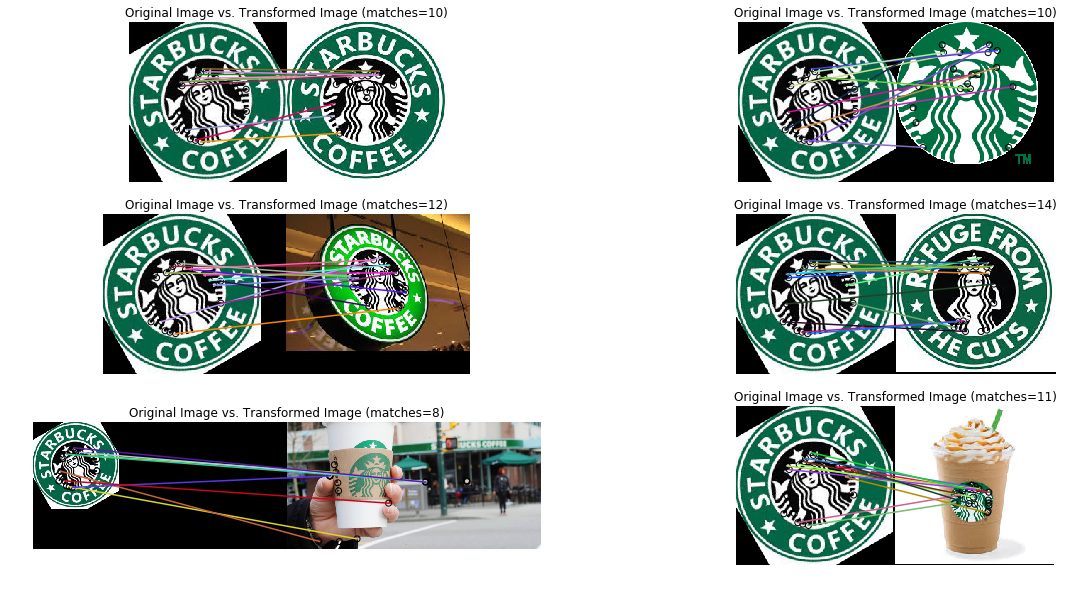

In [7]:
img_model_rotated = rotate(img_model, angle=30)

f, ax = plt.subplots(3, 2, figsize=(20, 10))

for idx, path in enumerate(sorted(glob('images/starbucks*'))):
    img = io.imread(path)[:, :, :3]
    display_correspondences(img_model_rotated, img, ax=ax[idx // 2][idx % 2])

plt.axis('off')
plt.show()

**Exercise 5.** **(Optional)** Repeat the experiments 2. to 3. with a new group of images. You could use Coca-Cola advertisements or from another famous brand, easily to find on internet.

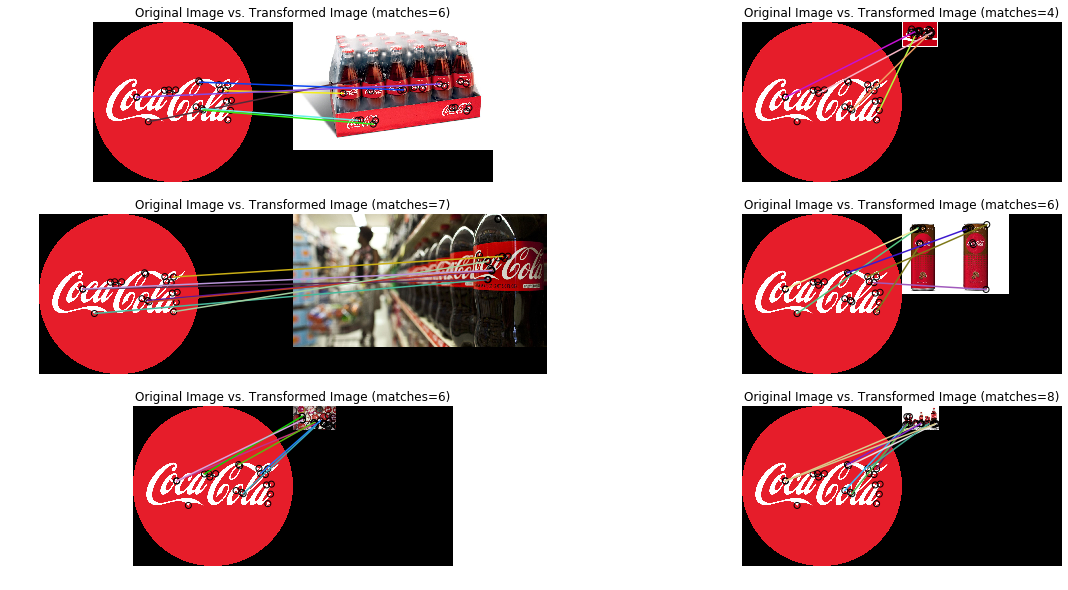

In [8]:
img_model_cocacola = io.imread('images/CocaColaImages/cocacola_logo.png')[:, :, :3]

f, ax = plt.subplots(3, 2, figsize=(20, 10))

for idx, path in enumerate(sorted(glob('images/CocaColaImages/*'))):
    if 'cocacola_logo' in path:
        continue
    
    img = io.imread(path)[:, :, :3]
    
    display_correspondences(img_model_cocacola, img, ax=ax[idx // 2][idx % 2])

plt.show()

**Exercise 6.** Analysis of the applied techniques and results

- What are the advantages of the ORB object detection with respect to the HOG object detector?

- What would happen if you analyse an image that does not contain the Starbucks logo (as is the case of "edificio.jpg")? 

- Could you think of ways of defining a quality measure for the correspondance between two images? (no need of implementing it) 

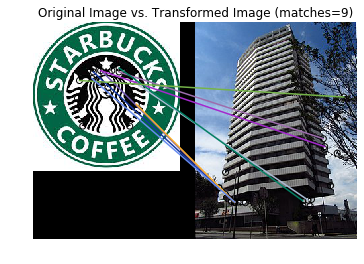

In [9]:
building = io.imread('images/edificio.jpg')
display_correspondences(img_model, building)

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
**What are the advantages of the ORB object detection with respect to the HOG object detector?**

SIFT tries to overcome certain disadvantages of HOG. In particular, SIFT is intended to be scale and rotation invariant, at least up to a point. However, ORB misses these advantages at least up to a point, but it's very computationally efficient.

**What would happen if you analyse an image that does not contain the Starbucks logo (as is the case of "edificio.jpg")?**

We have actually tested in in the above image, and false matches are detected. With a bigger max_ratio most of these false positives would have been filtered out.

**Could you think of ways of defining a quality measure for the correspondance between two images? (no need of implementing it)**

We can think of:

- The ratio of matches (the one used to filter out ambiguous matches with the max_ratio threshold)
- Orientations of matches: The "arrows" going from the points in the first image to the ones in the second image should have a relatively similar orientation (if every arrow has a different location, it's obvious that it's detecting a false positive). However, this could be problematic if the second image has a very different scale. 
</div>